In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Create Data

In [2]:
# data to plot
x = np.arange(-30, 30, 0.1)
def f(x): return np.sin(x)
def l(x): return x
def g(x): return 1

value = lambda x: np.array([[f(x), f(x), f(x)],
                            [l(x), l(x), l(x)],
                            [g(x), g(x), g(x)]])

def yield_value():
    for i in x:
        yield value(i)

# plot single

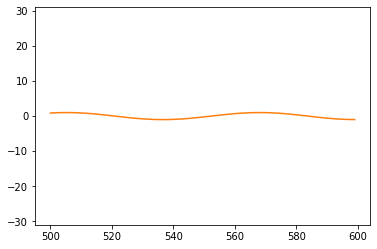

In [3]:
# plot single fig first
%matplotlib qt

buffer = []
interval = 100
i = 0

for i in range(len(x)):
    buffer.append(value(x[i]))
    plt.ylim((-31, 31))

    if i > interval:
        interval_buf = np.array(buffer[i - interval:i])
        x_axis = range(i - interval + 1, i + 1)
        plt.plot(x_axis, interval_buf[:, 0, 0], 'C1')
    else:
        interval_buf = np.array(buffer)
        x_axis = range(i + 1)
        plt.plot(x_axis, interval_buf[:, 0, 0], 'C1')
    plt.pause(1e-32)
    plt.clf()
    
%matplotlib inline
plt.ylim((-31, 31))
plt.plot(x_axis, interval_buf[:, 0, 0], 'C1')

# test subplot speed

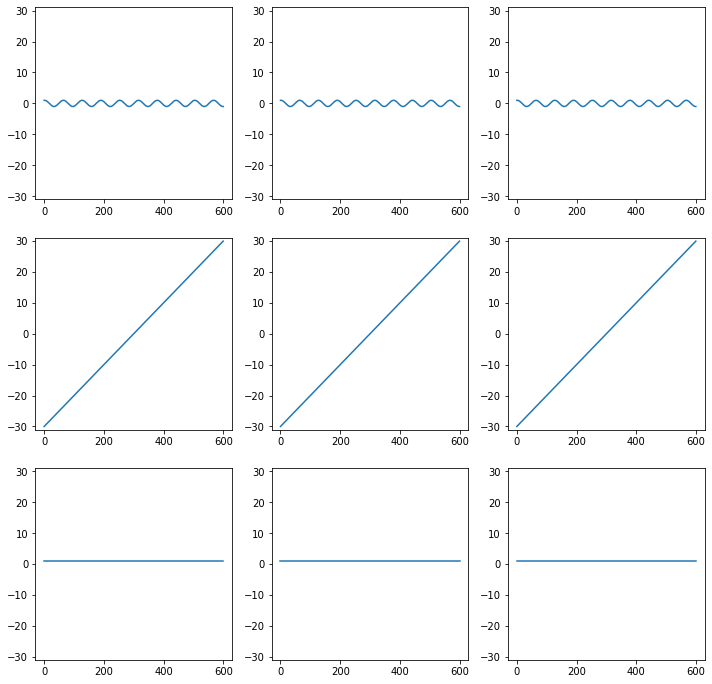

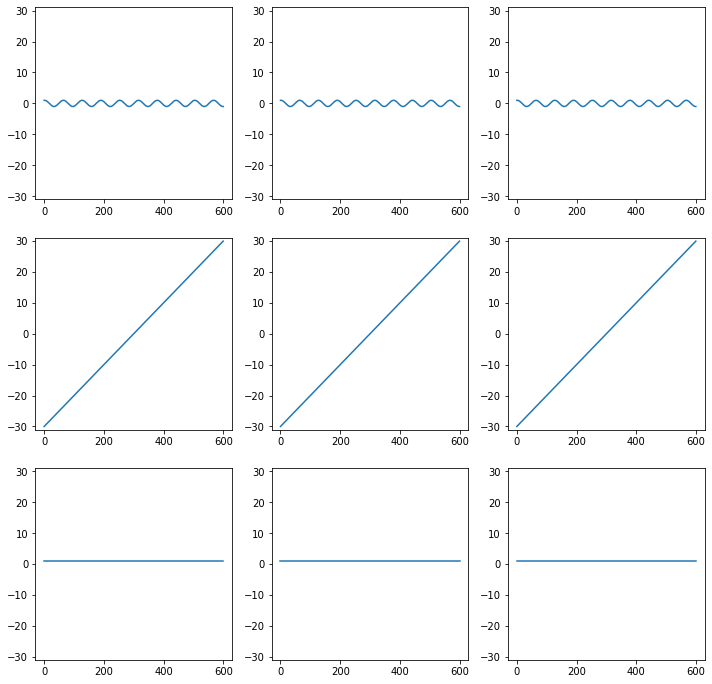

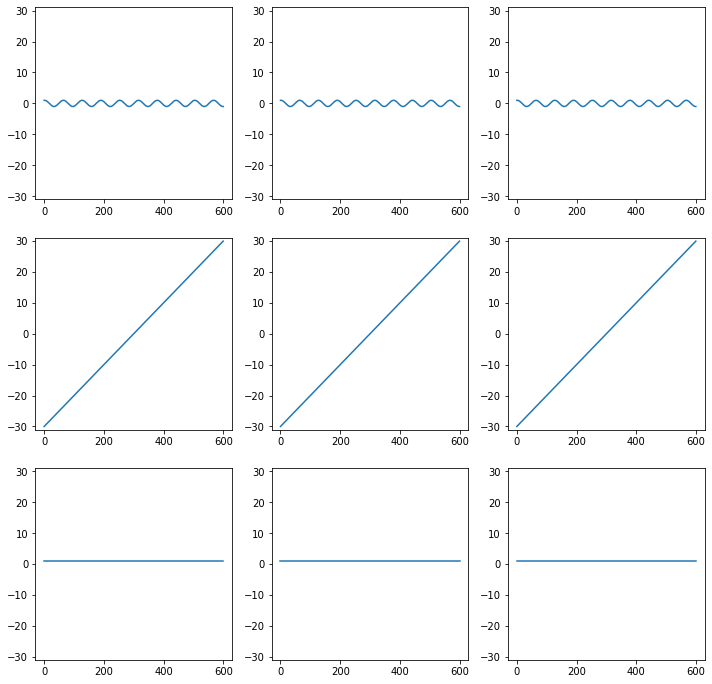

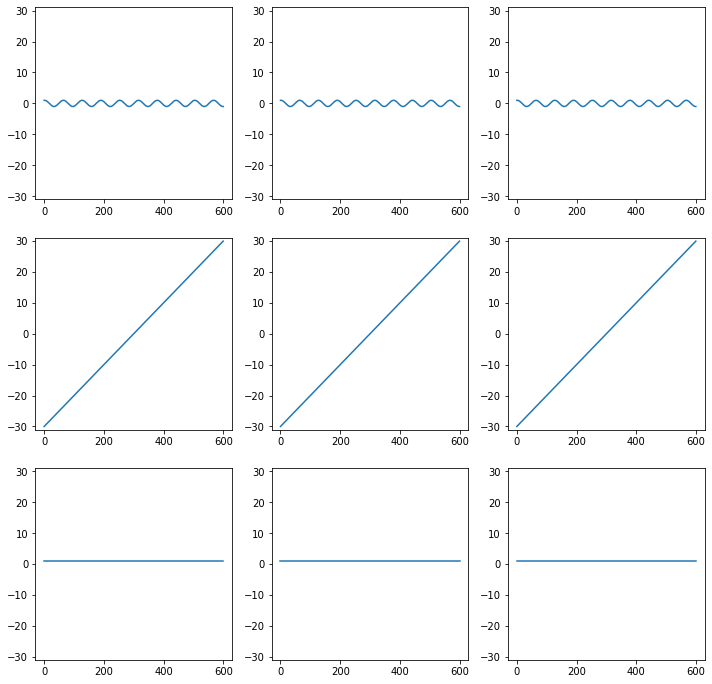

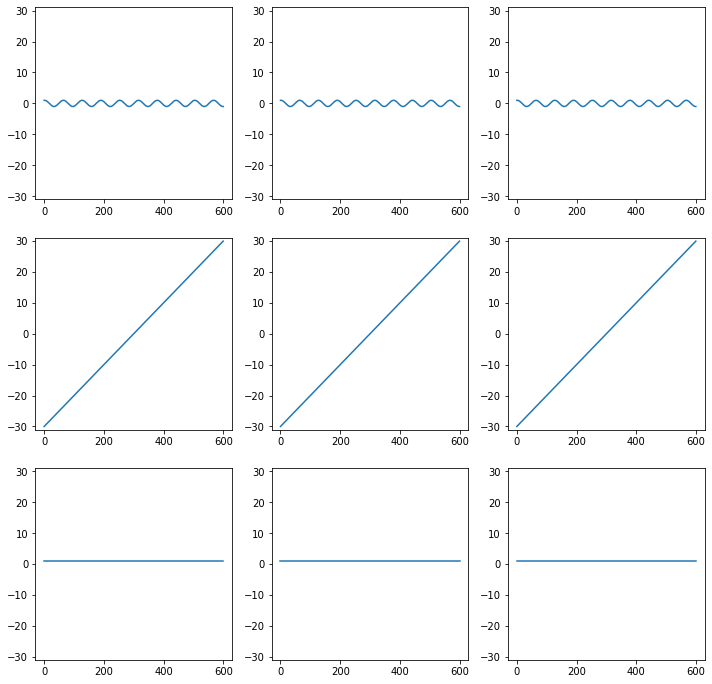

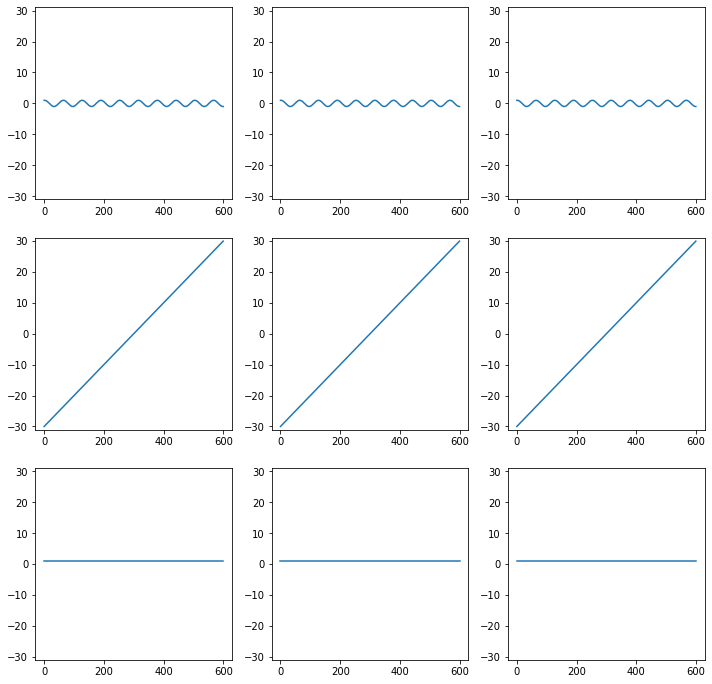

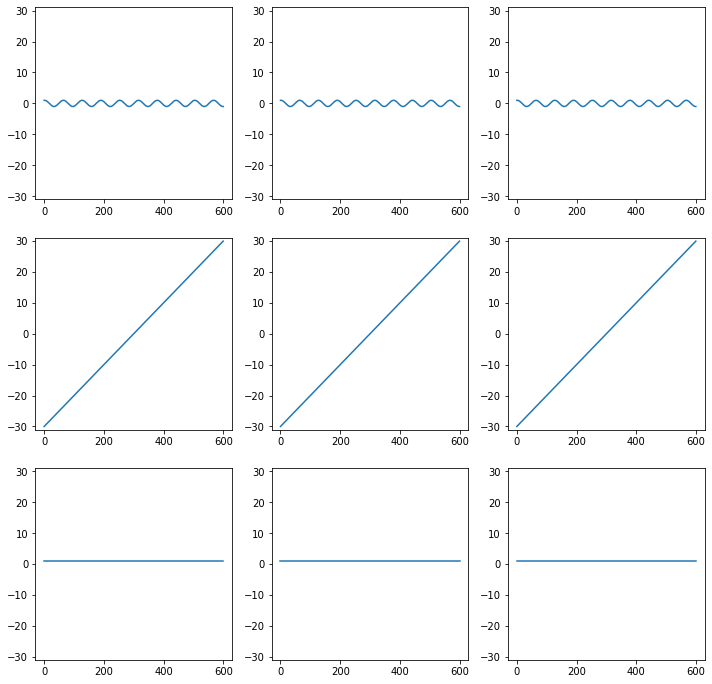

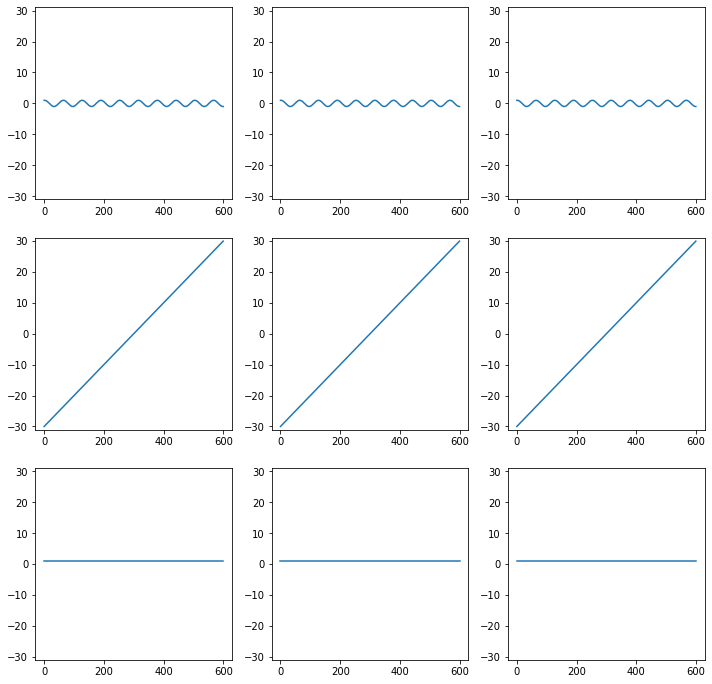

546 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
def plot_buffer(buffer):
    def subplot_(values, c):
        fig.add_subplot(3, 3, c)
        plt.ylim(-31, 31)
        # plt.title(title)
        plt.plot(values)

    interval_buf = np.array(buffer)
    x_axis = range(1, len(buffer) + 1)    

    fig = plt.figure(figsize=(12, 12))

    c = 1
    for j in range(3):
        for i in range(3):
            subplot_(interval_buf[:, j, i], c) 
            c += 1
    plt.show()    
%timeit plot_buffer(buffer)

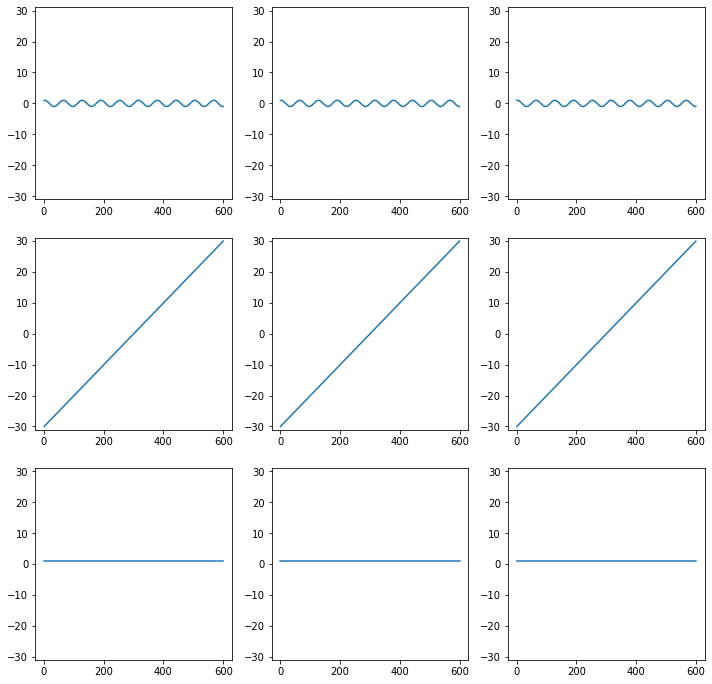

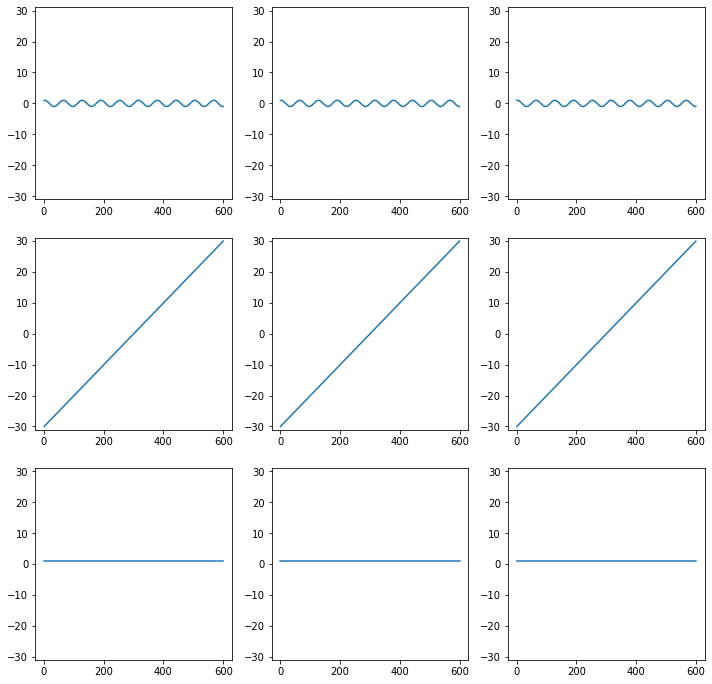

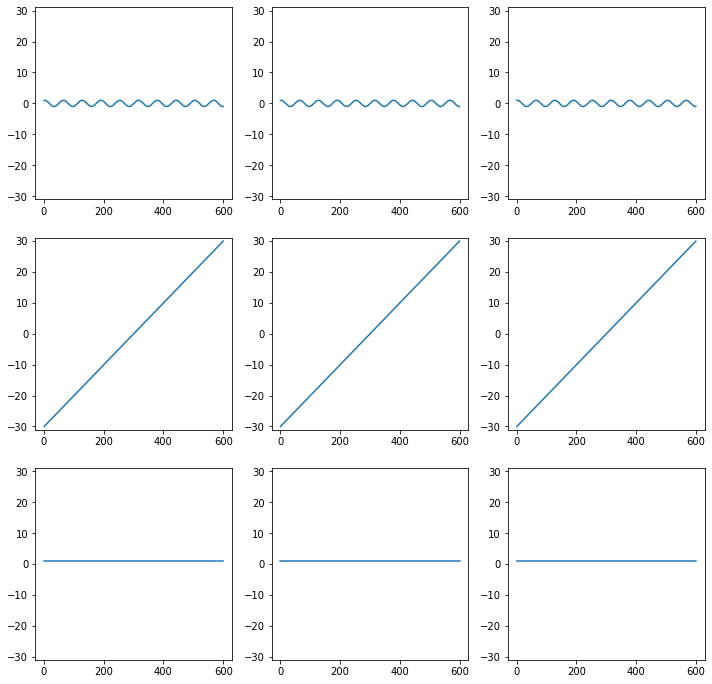

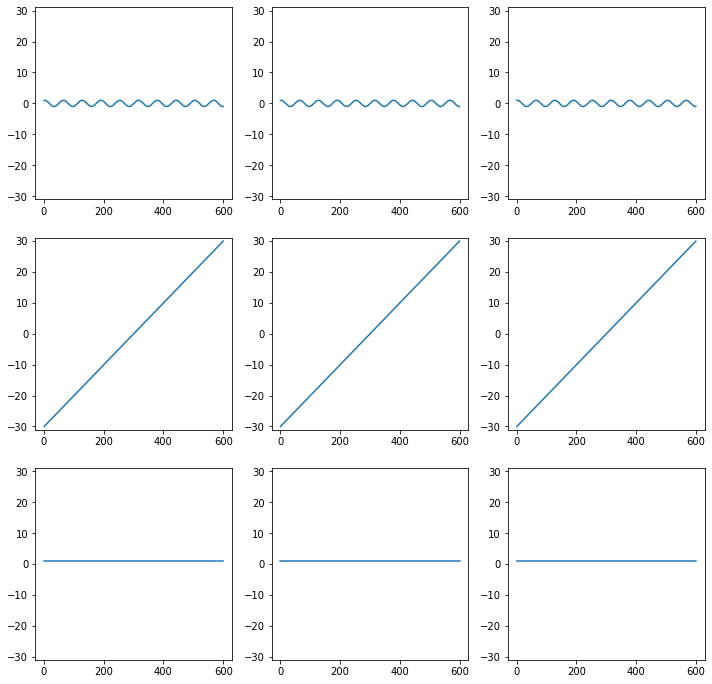

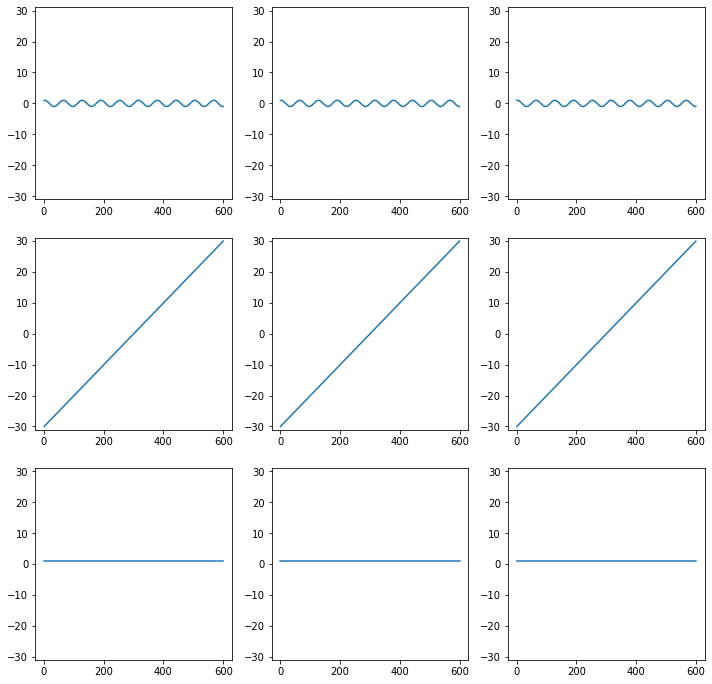

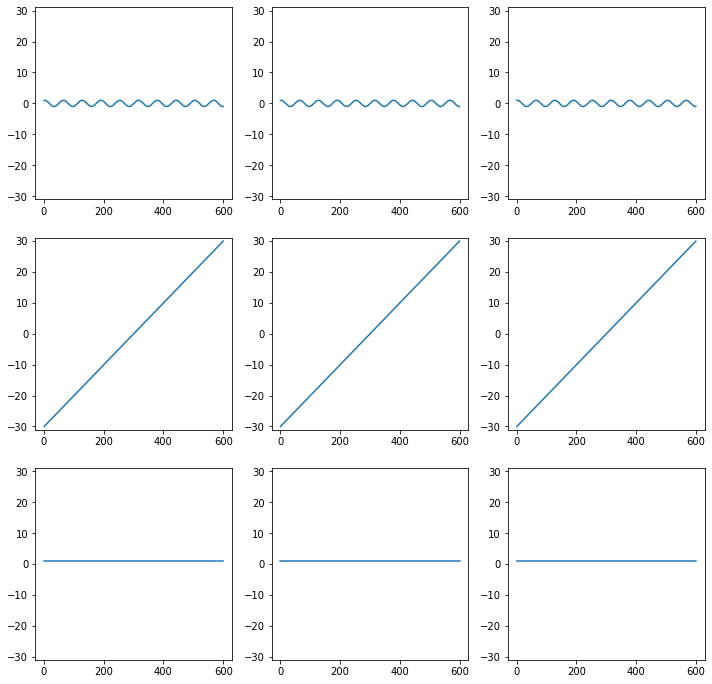

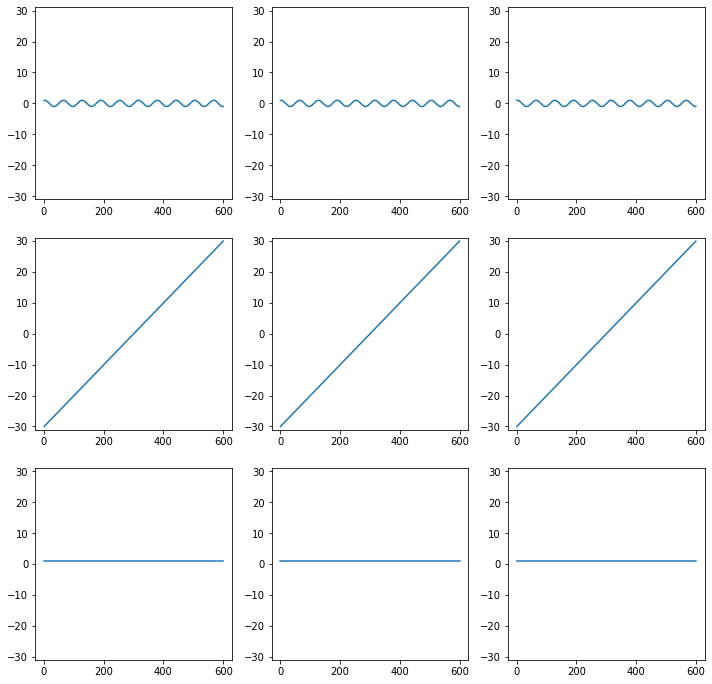

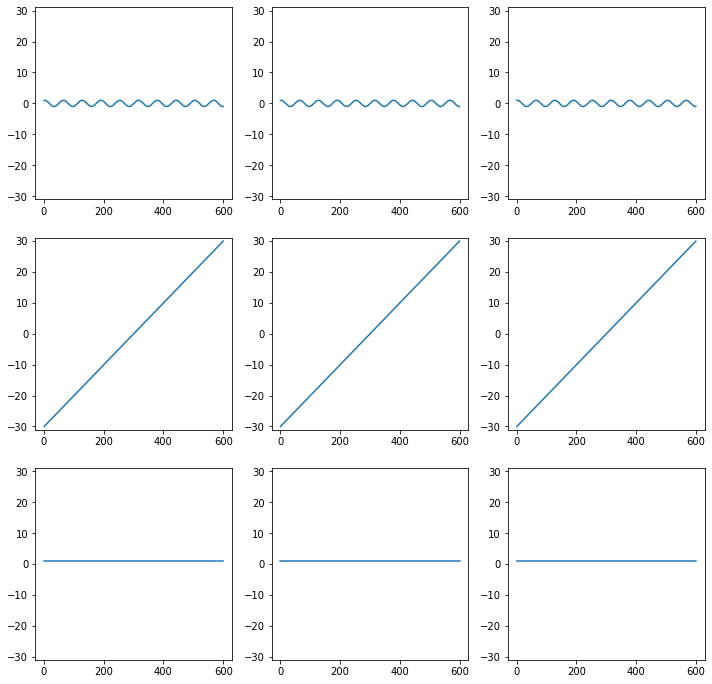

547 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%matplotlib inline
def plot_buffer(buffer):
    fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
    
    interval_buf = np.array(buffer)
    x_axis = range(1, len(buffer) + 1)    

    for j in range(3):
        for i in range(3):
            axarr[i][j].set_ylim(-31, 31)
            axarr[i][j].plot(x_axis, interval_buf[:, i, j])
    plt.show()
    
%timeit plot_buffer(buffer)

# realtime

- To speed up, only modify the data instead of plot again.

600


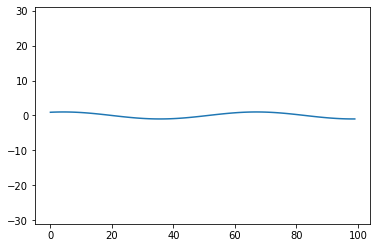

In [6]:
# plot single fig first
# 600 frames in 8.74 s
# 14.5667 ms per frame
%matplotlib qt

worker = yield_value()

interval = 100
buffer = np.zeros((interval, 3, 3)).tolist()

# create fig
fig, axarr = plt.subplots()
axarr.set_ylim(-31, 31)
x_axis = range(interval)

lines = []
interval_buf = np.array(buffer)
lines.append(axarr.plot(range(100), interval_buf[:interval, 0, 0], 'C0')[0])

num_plots = 0
for i, v in enumerate(worker, 1):
    
    buffer.append(v.tolist())
    interval_buf = np.array(buffer)
    lines[0].set_data(x_axis, interval_buf[i:i+interval, 0, 0])
    plt.pause(1e-16)

    num_plots += 1
    
print(num_plots)